# Check Tensorflow Version

In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
#tf.enable_eager_execution() # Remark for Tensorflow 1.x
print('Tensorflow Version:' + tf.__version__)

Tensorflow Version:2.6.0


## Import the Model

In [2]:
from tensorflow.python.keras.applications.vgg19 import VGG19

In [3]:
model = VGG19(
    include_top = False, # Exclude the top layers of VGG19, and only use the intermediate layers.
    weights = 'imagenet' # Make model pretrain on the imagenet dataset.
)

model.trainable = False # Make model not update the parameter and just use our algorithm, use it as output.
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Import Libraries and Helper Functions

In [4]:
# Load library to load image and covert image to arrary.
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
# Transform input image array into model able to read.
from tensorflow.python.keras.applications.vgg19 import preprocess_input 
from tensorflow.python.keras.models import Model # Library to initiate model.

import numpy as np
import matplotlib.pyplot as plt
import time

# Make plot within Jupyter notebook.
%matplotlib inline

## Image Processing and Display

In [5]:
# Define function to load and pre-process the image.
def load_and_process_image(image_path):
    img = load_img(image_path) # Load image.
    img = img_to_array(img) # Convert image to array.
    img = preprocess_input(img) # Convert image array to VGG19 readable format.
    img = np.expand_dims(img, axis = 0) # Expand the dimension of the array. Model is required 4 dimension tensor.
    return img

In [77]:
# Define function to de-process the image (from VGG19 format back to image array).
def deprocess(x):
    # From BGR to RGB
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1] # Change the order of the channel.
    
    x = np.clip(x, 0, 255).astype('uint8') # Clip (limit) the value back to color boundry.
    return x

# Define function to display the image.
def display_image(image):
    if len(image.shape) == 4: # Suppose image arrary would be in 4 dimension tensor.
        img = np.squeeze(image, axis = 0) # Squeeze 4 dimension tensor back into 3 dimension arrary as an image.
        
    img = deprocess(img)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

# Define function to display and save the image.
def display_and_save_image(image):
    if len(image.shape) == 4: # Suppose image arrary would be in 4 dimension tensor.
        img = np.squeeze(image, axis = 0) # Squeeze 4 dimension tensor back into 3 dimension arrary as an image.
        
    img = deprocess(img)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.axis('off')
    plt.savefig("result.png", dpi = 300, transparent = True, bbox_inches='tight', pad_inches = 0)
    return

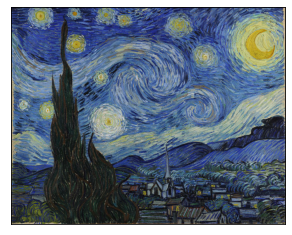

In [78]:
display_image(load_and_process_image('van_gogh_starry_night.jpg'))

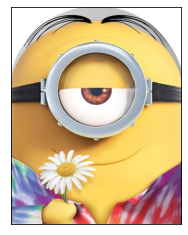

In [79]:
display_image(load_and_process_image('minions_head.jpg'))

## Content and Style Models

In [80]:
# Define the intermediate layer to extract from content image.
content_layer = 'block5_conv2'

# Define the intermediate layers to extract from style image.
style_layers = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]

# Configure model of content.
content_model = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output # Call VGG19 model and get the specific intermediate layers.
)

# Configure model of style.
style_models = [Model(inputs  = model.input,
                      # Call VGG19 model and get the specific intermediate layers.
                      outputs = model.get_layer(layer).output) for layer in style_layers]

## Content Cost

In [81]:
# Define function to calculate cost of content.
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G)) # Calculate the mean square deviation.
    return cost

## Gram Matrix

In [82]:
# Define function to use Gram Matrix to match feature distribution of images.
def gram_matrix(A):
    n_C = int(A.shape[-1]) # Get number of channel of image arrary.
    a = tf.reshape(A, [-1, n_C]) # Reshape 3 dimension arrary to 2 dimension arrary.
    n = tf.shape(a)[0] # Get the number of element.
    G = tf.matmul(a, a, transpose_a=True)
    return G / tf.cast(n, tf.float32)

## Style Cost

In [83]:
lam = 1. / len(style_models)

def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * lam
        
    return J_style

## Training Loop

In [92]:
# import math
# inf = math.inf

generated_images = [] # Initiate array to store intermediate images result.

# Define function for model training.
# a is alpha for content 10, b is beta for style 20, these are weight parameter to calculate the total cost.
def training_loop(content_path, style_path, iterations = 300, a = 10., b = 20.): 
    # initialise
    content = load_and_process_image(content_path) # Load the content image.
    style = load_and_process_image(style_path) # Load the style image.
    generated = tf.Variable(content, dtype = tf.float32) # Generate image variable from content image.
    #generated = tf.contrib.eager.Variable(content, dtype = tf.float32) # Remark for Tensorflow 1.x

    opt = tf.compat.v1.train.AdamOptimizer(learning_rate = 7.) # Define the optimizer and set the learning rate.
    #opt = tf.train.AdamOptimizer(learning_rate = 7.) # Remark for Tensorflow 1.x
    
    #best_cost = inf
    best_cost = 1e12+0.1
    best_image = None
    
    start_time = time.time() # Define the training start time as current time.
    
    for i in range(iterations):
        
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated) # Calculate the content cost of content image.
            J_style = style_cost(style, generated) # Calculate the style cost of style image.
            J_total = a * J_content + b * J_style # Calculate the total cost.
        
        grads = tape.gradient(J_total, generated) # Calculate the gradient of the total cost.
        opt.apply_gradients([(grads, generated)]) # Apply optimizer for gradient and generated image variable.
        
        # Looking for best image if it is under the best cost.
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy() # Set the best image equal to generated image variable in numpy array format.
            time_taken = time.time() - start_time
            print("Iteration : {}".format(i) + ', Total Loss : {:e}'.format(J_total) + 
                  ', Time Taken : {}'.format(time_taken))

            generated_images.append(generated.numpy())
        
    return best_image

In [93]:
best_image = training_loop('minions_head.jpg', 'van_gogh_starry_night.jpg')

Iteration : 0, Total Loss : 3.766734e+09, Time Taken : 0.7010049819946289
Iteration : 1, Total Loss : 2.043816e+09, Time Taken : 1.4009969234466553
Iteration : 2, Total Loss : 1.452958e+09, Time Taken : 2.0969886779785156
Iteration : 3, Total Loss : 1.390012e+09, Time Taken : 2.795983076095581
Iteration : 4, Total Loss : 1.227016e+09, Time Taken : 3.490975856781006
Iteration : 5, Total Loss : 9.727707e+08, Time Taken : 4.187968730926514
Iteration : 6, Total Loss : 8.166500e+08, Time Taken : 4.891960859298706
Iteration : 7, Total Loss : 7.200628e+08, Time Taken : 5.58995509147644
Iteration : 8, Total Loss : 6.411372e+08, Time Taken : 6.286945343017578
Iteration : 9, Total Loss : 5.794804e+08, Time Taken : 6.983937740325928
Iteration : 10, Total Loss : 5.276764e+08, Time Taken : 7.681929588317871
Iteration : 11, Total Loss : 4.757821e+08, Time Taken : 8.389919996261597
Iteration : 12, Total Loss : 4.286006e+08, Time Taken : 9.086915731430054
Iteration : 13, Total Loss : 3.904923e+08, Tim

## Plot the Results

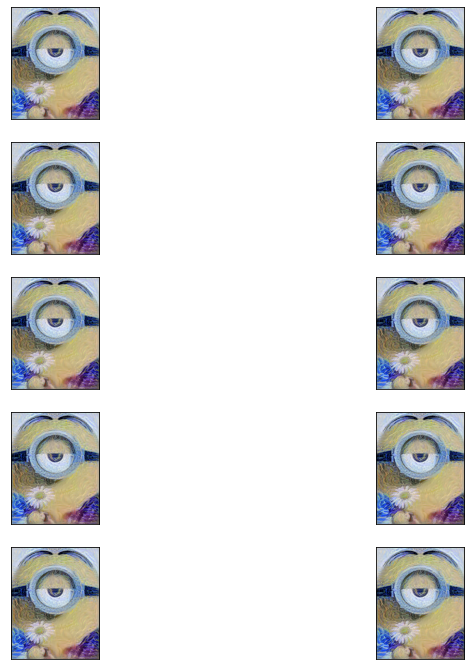

In [94]:
plt.figure(figsize = (12, 12))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    display_image(generated_images[i+289])
plt.show()

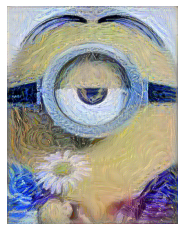

In [95]:
display_and_save_image(best_image)